# Nuovi Decessi e Terapie Intensive

Correlazione tra nuovi deceduti e terapie intensive.

> Max Pierini

In [1]:
import random
import numpy as np
import pandas as pd
import scipy.stats as sps
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib import dates as mdates
import matplotlib.gridspec as gridspec
import statsmodels.api as sm

from IPython.display import Markdown

In [2]:
sns.set_style('darkgrid')

In [3]:
df = pd.read_csv(
    'https://github.com/pcm-dpc/COVID-19/raw/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv',
    index_col='data', parse_dates=['data']
).sort_values('data')

In [4]:
df['nuovi_deceduti'] = df.deceduti.diff()

In [5]:
df['dec_int_rate'] = df.nuovi_deceduti / df.terapia_intensiva

In [6]:
df['dec_int_rate_filtered'] = df.dec_int_rate

Rapporto grezzo nuovi deceduti su terapie intensive:

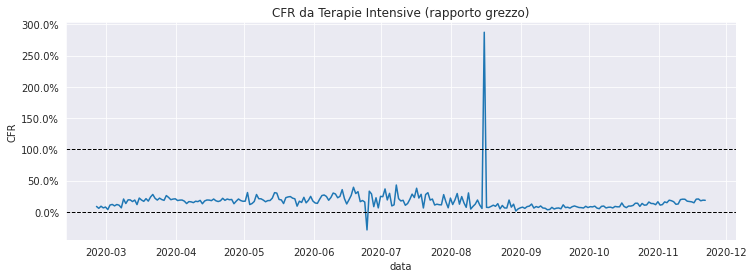

In [7]:
fig, ax = plt.subplots(figsize=(12, 4))
sns.lineplot(
    data=df,
    x='data', y='dec_int_rate',
    ax=ax
)
ax.axhline(0, ls='--', lw=1, color='k')
ax.axhline(1, ls='--', lw=1, color='k')
ax.set(
    ylabel='CFR',
    title='CFR da Terapie Intensive (rapporto grezzo)'
)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1,1))
plt.show()

Definizione e rimozione outliers (minori di 0% e maggiori di 100%)

In [8]:
outliers = ((df.dec_int_rate > 1) | (df.dec_int_rate < 0)).values.nonzero()
for outlier in outliers:
    for idx in outlier:
        print(f"{df.index[idx]}: {df.dec_int_rate[idx]:.2%}")
        df.at[df.index[idx], 'dec_int_rate_filtered'] = df.iloc[idx-1]['dec_int_rate_filtered']

2020-06-24 17:00:00: -28.97%
2020-08-15 17:00:00: 287.27%


Fit su polinomio di ottavo grado

In [9]:
params = np.polyfit(
    np.array(range(df.index.size))[1:], df.dec_int_rate_filtered.values[1:], 8
)
func = np.poly1d(params)
fitted = func(np.array(range(df.index.size))[1:])

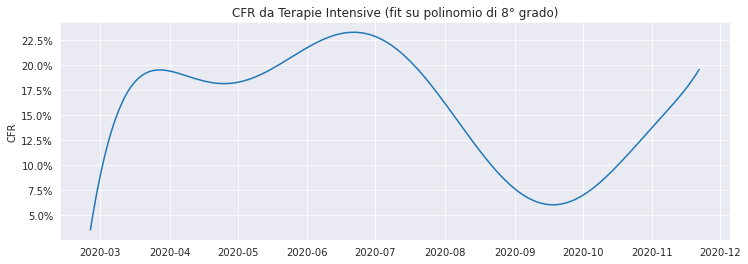

In [10]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(df.index[1:], fitted)
ax.set(
    ylabel='CFR',
    title='CFR da Terapie Intensive (fit su polinomio di 8° grado)'
)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1,1))
plt.show();

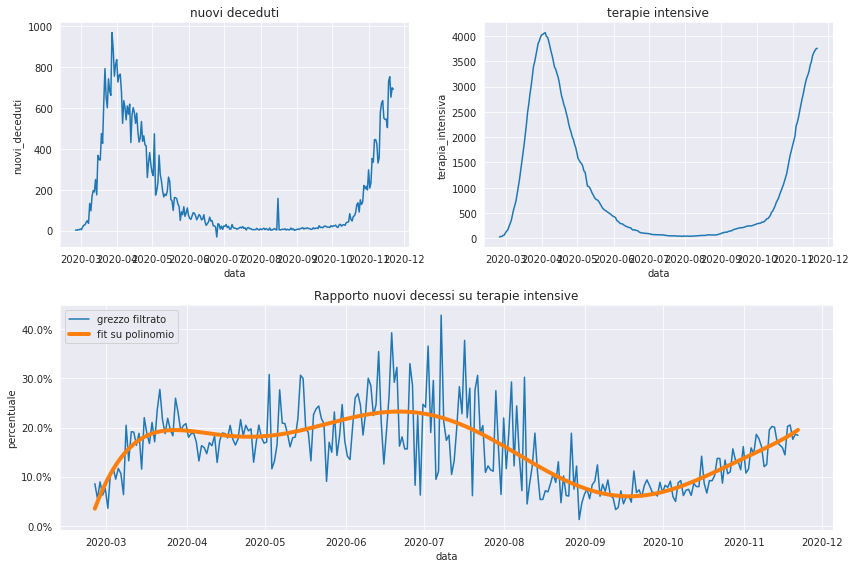

In [11]:
fig = plt.figure(tight_layout=True, figsize=(12, 8))
gs = gridspec.GridSpec(2, 2)

ax_sn = fig.add_subplot(gs[0, 0])
sns.lineplot(data=df, x='data', y='nuovi_deceduti', ax=ax_sn)
ax_sn.set_title('nuovi deceduti')

ax_dx = fig.add_subplot(gs[0, 1])
sns.lineplot(data=df, x='data', y='terapia_intensiva', ax=ax_dx)
ax_dx.set_title('terapie intensive')

ax = fig.add_subplot(gs[1, :])
sns.lineplot(
    data=df,
    x='data', y='dec_int_rate_filtered', 
    label='grezzo filtrato',
    ax=ax
)
ax.plot(df.index[1:], fitted, lw=4, label='fit su polinomio')
ax.legend(loc='upper left')
ax.set_ylabel('percentuale')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1,1))
ax.set_title('Rapporto nuovi decessi su terapie intensive')
plt.show()

Correlazione sulla linea temporale

In [12]:
df['mese'] = df.index.month_name()

In [13]:
df['mese_num'] = df.index.month

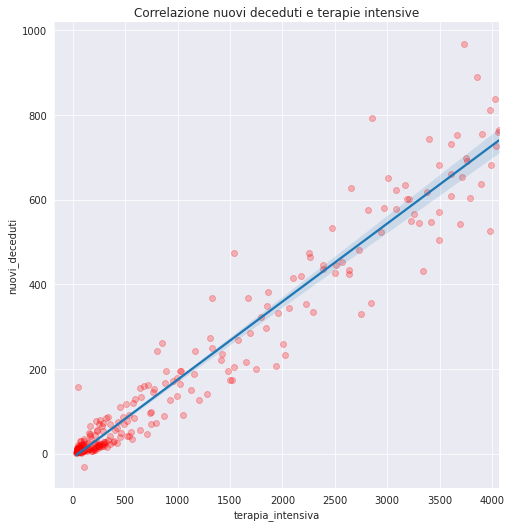

In [14]:
g = sns.lmplot(
    data=df,
    x='terapia_intensiva', y='nuovi_deceduti',
    x_jitter=.3, y_jitter=.3,
    order=1,
    height=7,
    scatter_kws={'alpha':.25, 'color':'r'}
)
g.set(
    title='Correlazione nuovi deceduti e terapie intensive'
)
plt.show()

In [15]:
model = sm.OLS.from_formula('nuovi_deceduti ~ terapia_intensiva', data=df)
results = model.fit()
display(results.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         nuovi_deceduti   R-squared:                       0.944
Model:                            OLS   Adj. R-squared:                  0.944
Method:                 Least Squares   F-statistic:                     4558.
Date:                Sat, 21 Nov 2020   Prob (F-statistic):          1.10e-170
Time:                        16:57:23   Log-Likelihood:                -1475.0
No. Observations:                 271   AIC:                             2954.
Df Residuals:                     269   BIC:                             2961.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -9.7545      4.435     -2.199      0.029     -18.486      -1.023
terapia_intensiva     0.1845      0.003     67.515      0.000       0.179       0.190
==============================================================================
Omnibus:                       68.095   Durbin-Watson:                   1.096
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              466.523
Skew:                           0.793   Prob(JB):                    4.96e-102
Kurtosis:                       9.229   Cond. No.                     2.11e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.11e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [16]:
fit_res = {}
grouped = df.groupby('mese_num')
for mese in grouped:
    fit_res.update({mese[0]: {}})
    _df = mese[1][['nuovi_deceduti', 'terapia_intensiva']]
    model = sm.OLS.from_formula('nuovi_deceduti ~ terapia_intensiva', data=_df[1:])
    results = model.fit()
    fit_res[mese[0]]['R2'] = results.rsquared
    fit_res[mese[0]]['Intercept'] = results.params.Intercept
    fit_res[mese[0]]['coefficient'] = results.params.terapia_intensiva

Correlazione nuovi deceduti e terapie intensive per mese:

$$
\textrm{nuovi_deceduti}_{\textrm{mese}} = \alpha + \beta \cdot \textrm{terapia_intensiva}_{\textrm{mese}}
$$

dove $\alpha$ è l'intercetta e $\beta$ il coefficiente di correlazione.

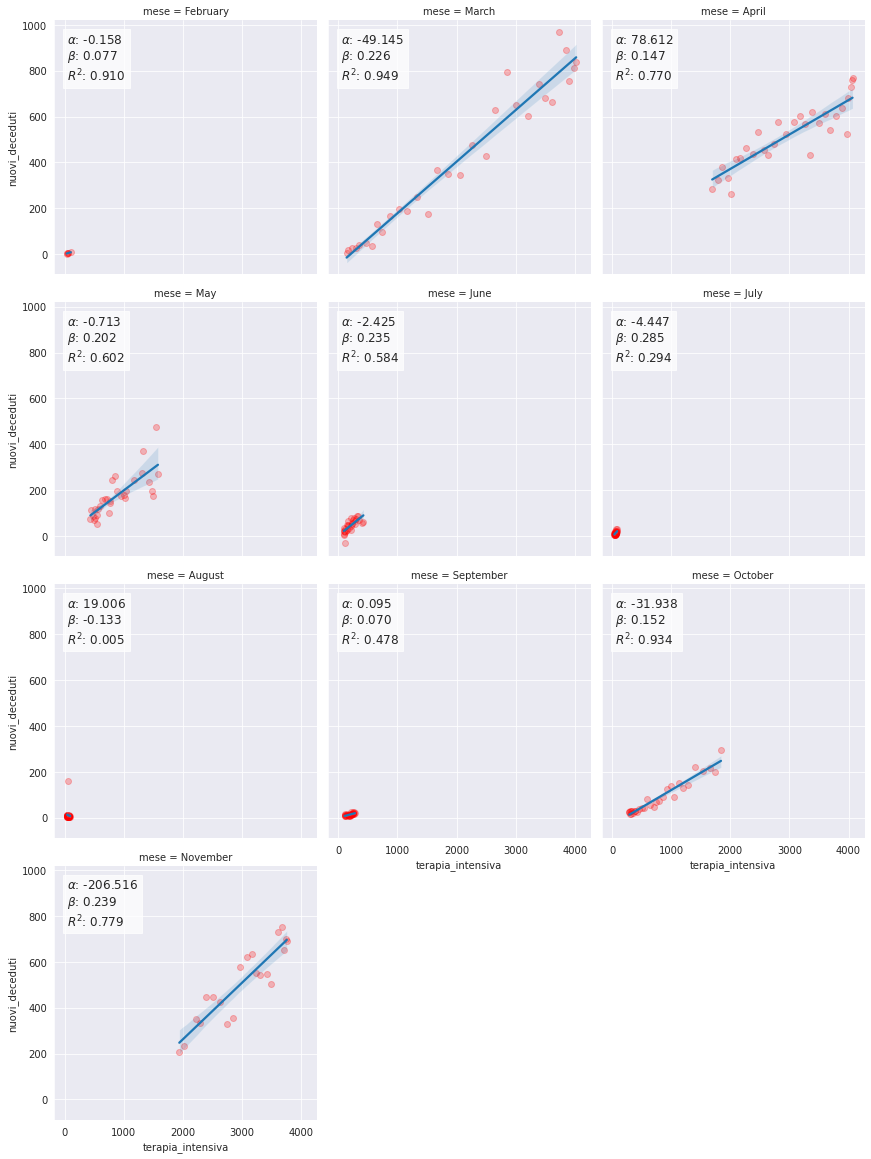

In [17]:
params = {}

g = sns.lmplot(
    data=df,
    x='terapia_intensiva', y='nuovi_deceduti',
    x_jitter=.3, y_jitter=.3,
    order=1,
    height=4, col='mese', col_wrap=3,
    #sharex=False, 
    #sharey=False,
    scatter_kws={'alpha':.25, 'color':'r'}
)
months = df.mese.unique()
for i, res in enumerate(fit_res):
    xlim = g.axes.flat[i].get_xlim()
    ylim = g.axes.flat[i].get_ylim()
    g.axes.flat[i].text(
        0.05, 0.85,
        fr"$\alpha$: {fit_res[res]['Intercept']:.3f}"+
        "\n"+
        fr"$\beta$: {fit_res[res]['coefficient']:.3f}"+
        "\n"+
        fr"$R^2$: {fit_res[res]['R2']:.3f}",
        ha='left', va='center', fontsize=12,
        transform=g.axes.flat[i].transAxes,
        bbox=dict(facecolor='w', alpha=0.75)
    )
    params.update({months[i]: {
        'alpha': fit_res[res]['Intercept'], 
        'beta': fit_res[res]['coefficient'],
        'R2': fit_res[res]['R2']
    }})

In [18]:
pd.DataFrame(params)

,February,March,April,May,June,July,August,September,October,November
alpha,-0.158044,-49.144705,78.611993,-0.712653,-2.425303,-4.446567,19.005875,0.094984,-31.937616,-206.515987
beta,0.076994,0.225814,0.147042,0.201721,0.234926,0.284943,-0.132562,0.069851,0.152086,0.239368
R2,0.910127,0.949058,0.770331,0.602185,0.583532,0.294261,0.004537,0.478192,0.933634,0.778546


In [19]:
lines = {
    'mese': [], 'terapia intensiva': [], 'nuovi deceduti': [], 'R2': []
}
x = np.linspace(0, df.terapia_intensiva.max(), 2)
for i, mese in enumerate(params):
    lines['mese'].append(mese)
    lines['mese'].append(mese)
    lines['terapia intensiva'].append(x[0])
    lines['terapia intensiva'].append(x[1])
    _y = params[mese]['alpha'] + params[mese]['beta'] * x
    lines['nuovi deceduti'].append(_y[0])
    lines['nuovi deceduti'].append(_y[1])
    lines['R2'].append(params[mese]['R2'])
    lines['R2'].append(params[mese]['R2'])

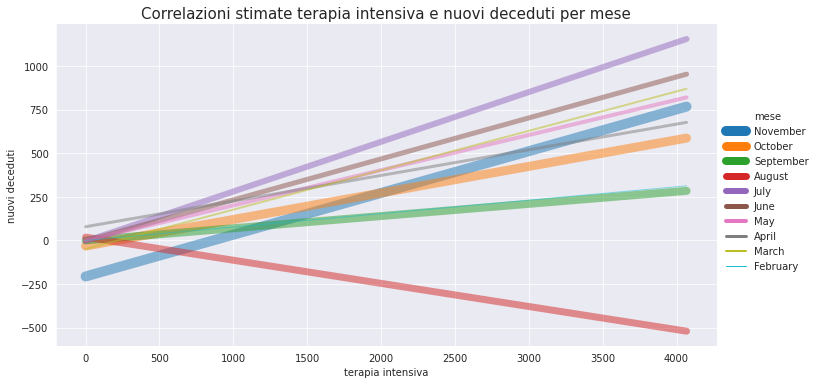

In [20]:
g = sns.relplot(
    kind='line',
    data=pd.DataFrame(lines).iloc[::-1],
    x='terapia intensiva', y='nuovi deceduti',
    hue='mese', size='mese', sizes=(1, 10),
    alpha=.5,
    aspect=2
)
g.axes.flat[0].set_title('Correlazioni stimate terapia intensiva e nuovi deceduti per mese', fontsize=15)
plt.show()